# Goal

Let's dive into VELMA's and baseline predictions of agreement with polarizing statements based on an export of [Paul's blog](https://paulbricman.com/reflections).

In [24]:
# Load ground-truth valuations file
import pandas as pd

df = pd.read_csv('~/Downloads/valuations.csv')

In [25]:
# Load predictions
from pathlib import Path
import pickle
import numpy as np

approaches = ['embs', 'nli_relative', 'nli_absolute', 'lm']
preds = {}

for approach in approaches:
    artifact_path = Path('..') / 'data' / 'blog_artifacts' / (approach + '.pkl')
    preds[approach] = pickle.load(open(artifact_path, 'rb'))
    df[approach] = [np.mean(e) for e in preds[approach]]

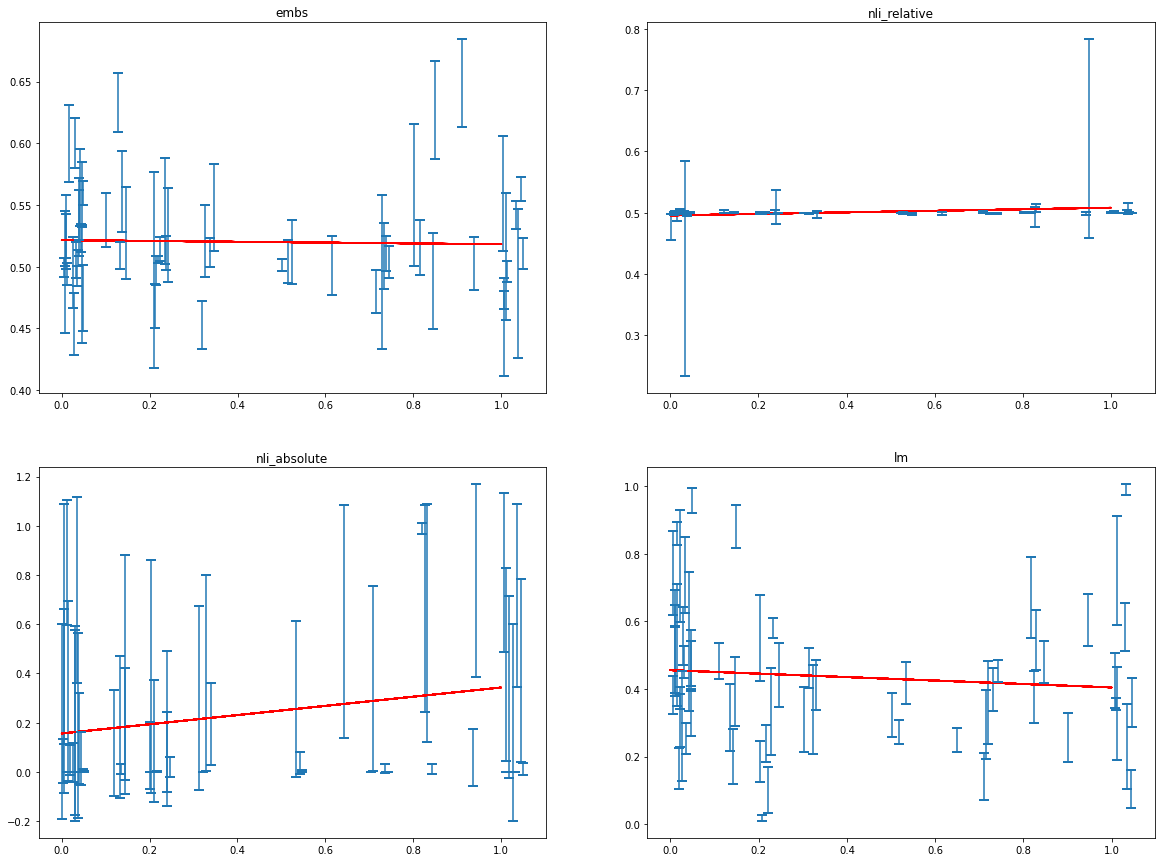

In [30]:
# Plot correlations
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))

for id, approach in enumerate(approaches):
    theta = np.polyfit(df['score'], [np.mean(e) for e in preds[approach]], 1)
    y_line = theta[1] + theta[0] * df['score']

    plt.subplot(2, 2, id + 1)
    plt.title(approach)
    plt.plot(df['score'], y_line, 'r')
    plt.errorbar(df['score'] + np.random.rand(62) * 0.05, [np.mean(e) for e in preds[approach]], [np.std(e) for e in preds[approach]], label=approach, linestyle='None', capsize=5, capthick=2)

plt.show()